In [32]:
# import sys and os to manipulate the path
import sys
import os

# import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Add the directory containing 'models' to the Python path
sys.path.append(os.path.join(os.getcwd(), '../'))

# import modules
from models.utils import plot_accuracy, fit_and_score, plot_confusion_matrix, resample_training_set, build_pipeline, smote_training_set
from models.utils import print_scores, cross_validated_metrics, plot_validated_metrics, fine_tune_model
from models.processors import DataProcessor, ModelInputs

# import models
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier

In [33]:
# Read and process CSV file
df = pd.read_csv('Sleep_health_and_lifestyle_dataset.csv')
processor = DataProcessor(df)
processor.process()

,Gender,Age,Sleep Duration,Quality of Sleep,Stress Level,BMI Category,Blood Pressure,Heart Rate,Daily Steps,Sleep Disorder,Daily Physical Activity
0,0,0,1,6,6,1,1,77,0,0,0.70
1,0,0,1,6,8,0,1,75,3,0,1.00
2,0,0,1,6,8,0,1,75,3,0,1.00
3,0,0,0,4,8,2,1,85,0,2,0.50
4,0,0,0,4,8,2,1,85,0,2,0.50
...,...,...,...,...,...,...,...,...,...,...,...
369,1,3,3,9,3,1,1,68,1,2,1.25
370,1,3,3,9,3,1,1,68,1,2,1.25
371,1,3,3,9,3,1,1,68,1,2,1.25
372,1,3,3,9,3,1,1,68,1,2,1.25


In [34]:
# Create model inputs
inputs = ModelInputs(df)
inputs.process()

In [35]:
# Instantiate models
models = {
    'Multinomial Logistic Regression': LogisticRegression(multi_class='multinomial', solver='lbfgs', max_iter=10000, random_state=42),
    'Random Forest': RandomForestClassifier(random_state=42),
    'GBC': GradientBoostingClassifier(random_state=42)
}

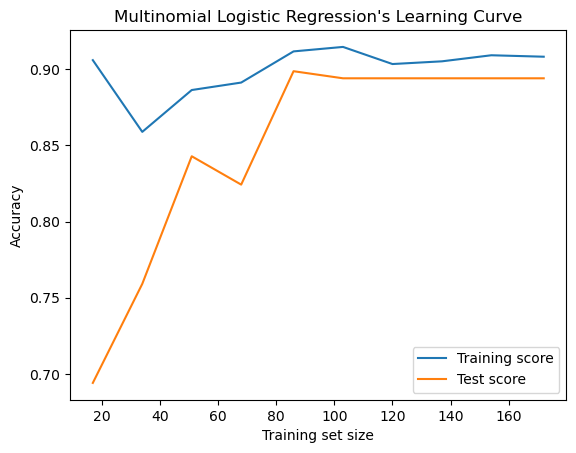

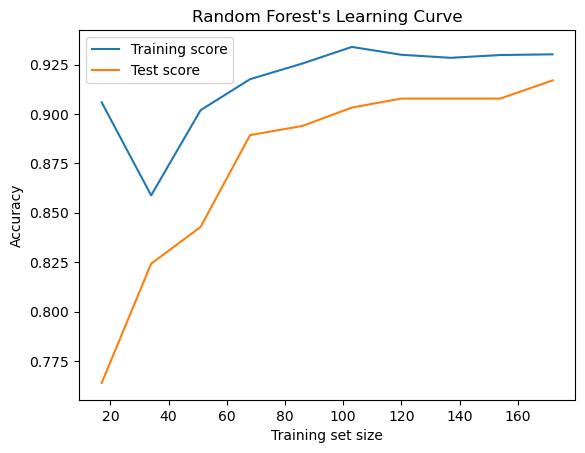

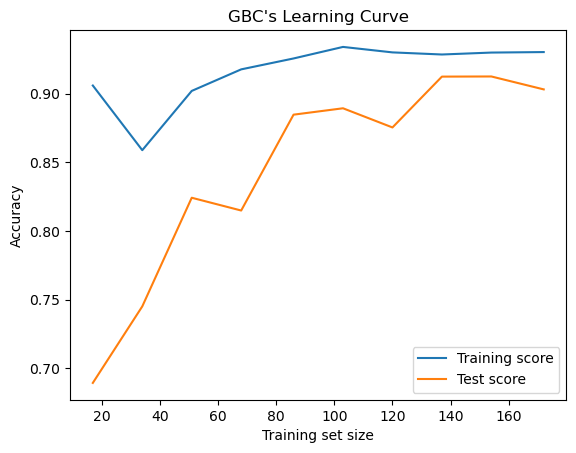

In [36]:
# Model training
scores = fit_and_score(models, inputs.X_train, inputs.X_test, inputs.y_train, inputs.y_test)

In [37]:
print_scores(scores)

Multinomial Logistic Regression Test:0.8987341772151899

Multinomial Logistic Regression Training:0.9027777777777778

Multinomial Logistic Regression Accuracy Score:0.8987341772151899

Multinomial Logistic Regression Learning Curve:None

Random Forest Test:0.8924050632911392

Random Forest Training:0.9305555555555556

Random Forest Accuracy Score:0.8924050632911392

Random Forest Learning Curve:None

GBC Test:0.8987341772151899

GBC Training:0.9305555555555556

GBC Accuracy Score:0.8987341772151899

GBC Learning Curve:None



In [ ]:
# Hyperparameter Tuning - Random Forest Classifier & GBC
random_forest_param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'bootstrap': [True, False]
}

gbc_param_grid = {
    'n_estimators': [50, 100, 200],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 4, 5],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'subsample': [0.8, 0.9, 1.0],
    'max_features': ['sqrt', 'log2']
}
random_forest_params = fine_tune_model(RandomForestClassifier(), random_forest_param_grid, inputs.X_train, inputs.y_train)
gbc_params = fine_tune_model(GradientBoostingClassifier(), gbc_param_grid, inputs.X_train, inputs.y_train)

tuned_models = {
    'Tuned Random Forest': RandomForestClassifier(**random_forest_params, random_state=42),
    'Tuned GBC': GradientBoostingClassifier(**gbc_params, random_state=42)
}
inputs = ModelInputs(df)
inputs.process(test_size=0.42)
scores = fit_and_score(tuned_models, inputs.X_train, inputs.X_test, inputs.y_train, inputs.y_test)

Fitting 5 folds for each of 216 candidates, totalling 1080 fits


In [ ]:
print_scores(scores)

In [ ]:
# Apply ADASYN for class imbalance, create pipeline for model experimentation

 
X_resampled, y_resampled = resample_training_set(inputs.X_train, inputs.y_train)


pipeline_models = { 'GBC Pipeline': build_pipeline(tuned_models['Tuned GBC']), 
                   'RF Pipeline': build_pipeline(tuned_models['Tuned Random Forest'])
}
scores = fit_and_score(pipeline_models, X_resampled, inputs.X_test, y_resampled, inputs.y_test)

In [ ]:
print_scores(scores)

In [ ]:
# SMOTE
X_resampled, y_resampled = smote_training_set(inputs.X_train, inputs.y_train)

pipeline_models = { 'GBC Pipeline': build_pipeline(tuned_models['Tuned GBC']), 
                   'RF Pipeline': build_pipeline(tuned_models['Tuned Random Forest'])
}
scores = fit_and_score(pipeline_models, X_resampled, inputs.X_test, y_resampled, inputs.y_test)

In [ ]:
print_scores(scores)